In [14]:
from pathlib import Path
from datasets import Dataset

def build_hf_dataset(data_dir: Path):
    image_paths, labels = [], []
    class_names = sorted([d.name for d in data_dir.iterdir() if d.is_dir()])
    name2idx = {n:i for i,n in enumerate(class_names)}
    for cname in class_names:
        for img_file in (data_dir / cname).glob('*.jpg'):
            image_paths.append(str(img_file))
            labels.append(name2idx[cname])
    ds = Dataset.from_dict({'image_path': image_paths, 'label': labels})
    return ds, class_names

# Test building
hf_ds, class_names = build_hf_dataset(Path('images'))
print(class_names, len(hf_ds))

['Abomasnow', 'Abra', 'Absol', 'Accelgor', 'Aegislash', 'Aerodactyl', 'Aggron', 'Aipom', 'Alakazam', 'Alcremie', 'Alomomola', 'Altaria', 'Amaura', 'Ambipom', 'Amoonguss', 'Ampharos', 'Anorith', 'Appletun', 'Applin', 'Araquanid', 'Arbok', 'Arcanine', 'Arceus', 'Archen', 'Archeops', 'Arctovish', 'Arctozolt', 'Ariados', 'Armaldo', 'Aromatisse', 'Aron', 'Arrokuda', 'Articuno', 'Audino', 'Aurorus', 'Avalugg', 'Axew', 'Azelf', 'Azumarill', 'Azurill', 'Bagon', 'Baltoy', 'Banette', 'Barbaracle', 'Barboach', 'Barraskewda', 'Basculin', 'Bastiodon', 'Bayleef', 'Beartic', 'Beautifly', 'Beedrill', 'Beheeyem', 'Beldum', 'Bellossom', 'Bellsprout', 'Bergmite', 'Bewear', 'Bibarel', 'Bidoof', 'Binacle', 'Bisharp', 'Blacephalon', 'Blastoise', 'Blaziken', 'Blipbug', 'Blissey', 'Blitzle', 'Boldore', 'Boltund', 'Bonsly', 'Bouffalant', 'Bounsweet', 'Braixen', 'Braviary', 'Breloom', 'Brionne', 'Bronzong', 'Bronzor', 'Bruxish', 'Budew', 'Buizel', 'Bulbasaur', 'Buneary', 'Bunnelby', 'Burmy', 'Butterfree', 'Buzz

In [15]:
from torch.utils.data import Dataset as TorchDataset
from PIL import Image

class PokemonTorchDataset(TorchDataset):
    def __init__(self, hf_ds, transform=None):
        self.ds = hf_ds
        self.transform = transform
    def __len__(self):
        return len(self.ds)
    def __getitem__(self, idx):
        item = self.ds[int(idx)]
        img = Image.open(item['image_path']).convert('RGB')
        label = item['label']
        if self.transform:
            img = self.transform(img)
        return img, label

In [16]:
import torch.nn as nn
from torchvision import models

class PokemonClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = models.resnet18(pretrained=True)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)
    def forward(self, x):
        return self.backbone(x)

In [17]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter

def train_model(
    data_dir: str,
    batch_size: int = 32,
    epochs: int = 10,
    lr: float = 1e-4,
    test_split: float = 0.2,
    log_dir: str = './runs',
    save_path: str = './best_model.pth'
):
    # Prepare HF dataset and transforms
    hf_ds, class_names = build_hf_dataset(Path(data_dir))
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ])
    full = PokemonTorchDataset(hf_ds, transform)
    # Split
    n_train = int(len(full)*(1-test_split))
    train_ds, val_ds = random_split(full, [n_train, len(full)-n_train])
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = PokemonClassifier(len(class_names)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    writer = SummaryWriter(log_dir=log_dir)

    best_acc = 0.0
    for epoch in range(1, epochs+1):
        # Training
        model.train()
        running_loss = correct = total = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward(); optimizer.step()
            running_loss += loss.item()*imgs.size(0)
            preds = outputs.argmax(dim=1)
            correct += preds.eq(labels).sum().item(); total += labels.size(0)
        train_loss = running_loss/total; train_acc = correct/total
        writer.add_scalar('Train/Loss', train_loss, epoch)
        writer.add_scalar('Train/Accuracy', train_acc, epoch)

        # Validation
        model.eval()
        val_loss = val_correct = val_total = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()*imgs.size(0)
                preds = outputs.argmax(dim=1)
                val_correct += preds.eq(labels).sum().item(); val_total += labels.size(0)
        val_loss /= val_total; val_acc = val_correct/val_total
        writer.add_scalar('Val/Loss', val_loss, epoch)
        writer.add_scalar('Val/Accuracy', val_acc, epoch)

        print(f"Epoch {epoch}/{epochs}  train_loss={train_loss:.4f}  train_acc={train_acc:.4f}  val_loss={val_loss:.4f}  val_acc={val_acc:.4f}")
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), save_path)
    writer.close()
    print(f"Best validation accuracy: {best_acc:.4f}")
    return class_names

In [18]:
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F

def evaluate_model(
    data_dir: str,
    class_names,
    save_path: str = './best_model.pth',
    batch_size: int = 32,
    test_split: float = 0.2,
    num_examples: int = 8
):
    hf_ds, _ = build_hf_dataset(Path(data_dir))
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
    full = PokemonTorchDataset(hf_ds, transform)
    n_train = int(len(full)*(1-test_split))
    _, test_ds = random_split(full, [n_train, len(full)-n_train], )
    test_loader = DataLoader(test_ds, batch_size=batch_size)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = PokemonClassifier(len(class_names)).to(device)
    model.load_state_dict(torch.load(save_path, map_location=device))
    model.eval()

    all_preds, all_labels = [], []
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.tolist())
    acc = sum(p==l for p,l in zip(all_preds, all_labels))/len(all_labels)
    print(f"Test Accuracy: {acc:.4f}")

    # Visualize examples
    idxs = random.sample(range(len(test_ds)), num_examples)
    plt.figure(figsize=(12, num_examples//4*3))
    for i, idx in enumerate(idxs, 1):
        img, label = test_ds[idx]
        out = model(img.unsqueeze(0).to(device))
        prob = F.softmax(out, dim=1)[0]
        pred = prob.argmax().item()
        img_np = img.permute(1,2,0).numpy() * 0.229 + 0.485
        plt.subplot(num_examples//4, 4, i)
        plt.imshow(img_np.clip(0,1)); plt.axis('off')
        plt.title(f"GT: {class_names[label]}\nPred: {class_names[pred]} ({prob[pred]:.2f})")
    plt.tight_layout(); plt.show()

Epoch 1/10  train_loss=6.9137  train_acc=0.0205  val_loss=6.6629  val_acc=0.0339
Epoch 2/10  train_loss=5.1218  train_acc=0.3596  val_loss=6.3127  val_acc=0.0739
Epoch 3/10  train_loss=3.9577  train_acc=0.6928  val_loss=5.9921  val_acc=0.1277
Epoch 4/10  train_loss=3.0280  train_acc=0.9036  val_loss=5.7745  val_acc=0.2076
Epoch 5/10  train_loss=2.2457  train_acc=0.9715  val_loss=5.5616  val_acc=0.2675
Epoch 6/10  train_loss=1.5988  train_acc=0.9940  val_loss=5.3690  val_acc=0.3134
Epoch 7/10  train_loss=1.0880  train_acc=0.9990  val_loss=5.1966  val_acc=0.3353
Epoch 8/10  train_loss=0.7411  train_acc=0.9985  val_loss=5.0279  val_acc=0.3792
Epoch 9/10  train_loss=0.4896  train_acc=0.9990  val_loss=4.8823  val_acc=0.4291
Epoch 10/10  train_loss=0.3328  train_acc=0.9990  val_loss=4.7748  val_acc=0.4531
Best validation accuracy: 0.4531


C:\Users\pnkdl\AppData\Local\Temp\ipykernel_22344\1390805999.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path, map_location=de

Test Accuracy: 0.8782


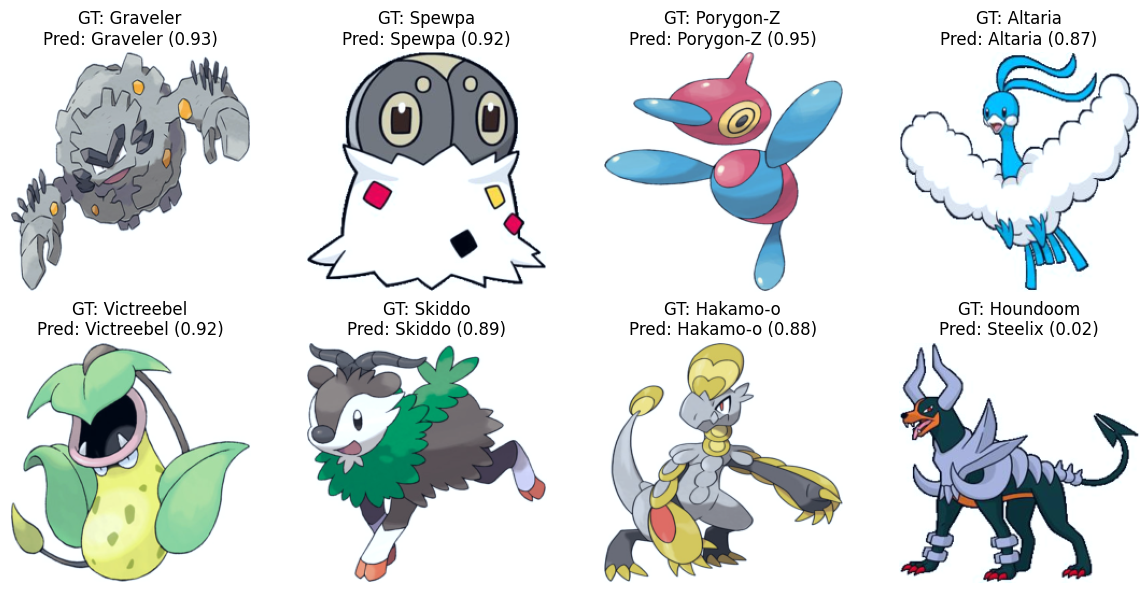

In [19]:
DATA_DIR = './images'

class_names = train_model(
    data_dir=DATA_DIR,
    batch_size=32,
    epochs=10,
    lr=1e-4,
    test_split=0.2,
    log_dir='./runs',
    save_path='./best_model.pth'
)

evaluate_model(
    data_dir=DATA_DIR,
    class_names=class_names,
    save_path='./best_model.pth',
    batch_size=32,
    test_split=0.2,
    num_examples=8
)

## Выводы

- **Проблемы:**
  - Сильное переобучение
  - Модель плохо обобщает на валидационные данные.

- **Решено:**
  - Рабочий пайплайн обучения и оценки.
  - Визуализация предсказаний и логов в TensorBoard.

- **Метрики:**
  - Точность на обучении: 87.8%
  - Лучшая точность на валидации: 45.3%

- **Улучшения:**
  - Аугментация данных
  - Регуляризация и scheduler
